3.6.0
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


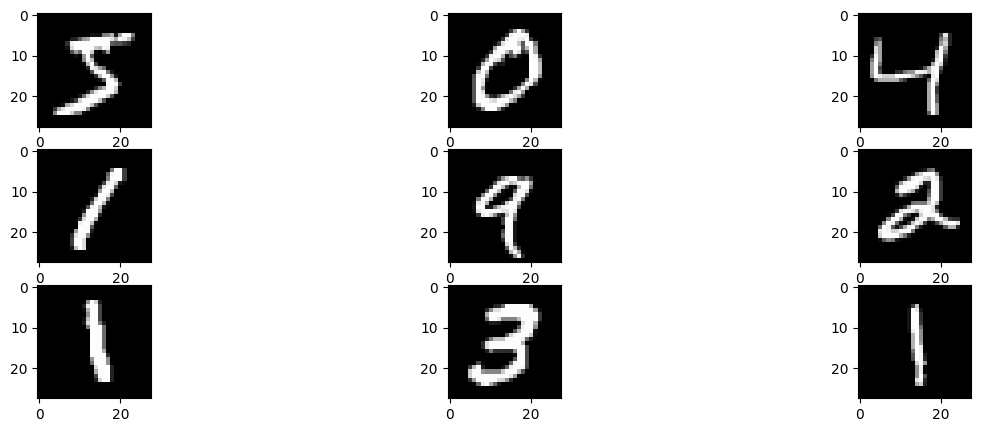

In [146]:
"""
    Creating a convolutional neural network to classify MNIST images.
"""

import os

os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np

print(keras.__version__)

from matplotlib import pyplot as plt

with np.load("./mnist.npz", allow_pickle=True) as f:
    X_train, y_train = f["x_train"], f["y_train"]
    X_test, y_test = f["x_test"], f["y_test"]

print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  ' + str(X_test.shape))
print('Y_test:  ' + str(y_test.shape))

plt.figure(figsize=(15, 5))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()


In [147]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [148]:
X_train[0].shape

(28, 28)

In [149]:
X_train = X_train.reshape((60000, 1, 28, 28))
X_test = X_test.reshape((10000, 1, 28, 28))

In [150]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [151]:
import torch.nn as nn

In [185]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [186]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10, dry_run=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [187]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [188]:
use_mps = torch.backends.mps.is_available()

In [189]:
device = torch.device("mps")

In [197]:
train_transformed = transform(torch.from_numpy(X_train).float())
val_transformed = transform(torch.from_numpy(X_test).float())

In [198]:
train_dataset = torch.utils.data.TensorDataset(train_transformed, torch.from_numpy(y_train).float())
val_dataset = torch.utils.data.TensorDataset(val_transformed, torch.from_numpy(y_test).float())

In [199]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32)
test_loader = torch.utils.data.DataLoader(val_dataset,batch_size=32)

In [200]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.001)

In [201]:
epochs = 10

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: -2.448486

Test set: Average loss: -8.3303, Accuracy: 850/10000 (8%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -2.871221

Test set: Average loss: -8.6365, Accuracy: 855/10000 (9%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -3.303332

Test set: Average loss: -8.9529, Accuracy: 861/10000 (9%)

Train Epoch: 4 [0/60000 (0%)]	Loss: -3.741862

Test set: Average loss: -9.2644, Accuracy: 873/10000 (9%)

Train Epoch: 5 [0/60000 (0%)]	Loss: -4.186673

Test set: Average loss: -9.5772, Accuracy: 883/10000 (9%)

Train Epoch: 6 [0/60000 (0%)]	Loss: -4.637578

Test set: Average loss: -9.8977, Accuracy: 888/10000 (9%)

Train Epoch: 7 [0/60000 (0%)]	Loss: -5.098066

Test set: Average loss: -10.2163, Accuracy: 897/10000 (9%)

Train Epoch: 8 [0/60000 (0%)]	Loss: -5.564154

Test set: Average loss: -10.5434, Accuracy: 905/10000 (9%)

Train Epoch: 9 [0/60000 (0%)]	Loss: -6.030770

Test set: Average loss: -10.8682, Accuracy: 915/10000 (9%)

Train Epoch: 10 [0/60000 (0%)]	Loss: -6.499

In [196]:
torch.save(model.state_dict(), "mnist_cnn.pt")